<a href="https://colab.research.google.com/github/Juanba98/AdversarialPatch/blob/main/Carlini%26Wagner_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
"""
Carlini-Wagner attack (http://arxiv.org/abs/1608.04644).
Referential implementation:
- https://github.com/carlini/nn_robust_attacks.git (the original implementation)
- https://github.com/kkew3/pytorch-cw2/blob/master/cw.py
"""

import operator as op

from typing import Union, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


from torchvision import datasets
from torchvision import transforms

import torch.nn.functional as F


# L2 attack
To ensure the modifitacions yields to a valid image, we use the third method of box contraints at the paper and we define  $\delta$ as:

$$\delta_{i} = \frac{1}{2}(tanh(w_{i}) + 1) - x_{i} $$

and we optimize over the variable $w$

\

## Attack

Given x, and choosing a target class $t$  ($t \neq C^{*}(x)$, beeing $C^{*}(x)$) the correct label of x we search for a $w$ that solves



$$minimize \ ||\delta||^{2}_{2} + c \cdot f(x + \delta)$$ 



with $f$ defined as

$$f(x') = max(max\{Z(x')_i :  i \neq t\} - Z(x')_t, -\kappa)$$

To control the confidence with which missclasifation ocurrs we adjust κ but we wil set it to 0 for out attack

 
## L2 formula


## Hiperparametros

In [ ]:
SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
K = 0             # (kappa) how strong the adversarial example should be (confidence)
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

In [ ]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:


class L2Adversary(object):
  
 
  def __init__(self, targeted=True, k=K, c_range=(INITIAL_CONST, 1e10),
                  search_steps=SEARCH_STEPS, max_steps=1000, abort_early=ABORT_EARLY,
                  box=(-1., 1.), learning_rate = LEARNING_RATE):


  
    self.targeted = targeted # type: bool param: True for targeted attack
    self.k = float(k) #type: int param: confidence
    self.c_range = (float(c_range[0]), float(c_range[1])) # type: Tuple[float, float], param: range of the constat c
    self.binary_search_steps = search_steps #type: int param: number of steps to perform binary search to find optimal c
    self.max_steps = max_steps #type: int param: Maximum number of iterations
    self.abort_early = abort_early #type bool param: If true, we break when the gradient descent gets stuck
    self.box = tuple(map(float, box))  # type: Tuple[float, float], param: (max,min) pixel value
    self.learning_rate = learning_rate #type: float param: the learning rate for Adam optimizer used over the perturbation
    self.ae_tol = 1e-4  # tolerance of early abort
    
    #?
    self.repeat = (self.binary_search_steps >= 10)

    #Used for the affine transformation fo the change-of-variable
    self.box_mul = (self.box[1]-self.box[0])/2
    self.box_plus = (self.box[1]+self.box[0])/2

  def attack(self,model, inputs, targets, num_classes ):


    '''
    :param model: Model to attack :type: nn.Module  
    :param inputs: original images of dimension [B x C x H x W].
    :param targets: the original image labels, or the attack target, of
              dimension [B]. If ``self.targeted`` is ``True``, then ``targets``
              is treated as the attack targets, otherwise the labels.
              :type: ???????????????????????
    :param num_clases: number of clases of the model :type: int  
    :return: Adversarial examples of dimension [B X C x H x W]
    '''


    # sanity check
    assert isinstance(model, nn.Module)
    assert len(inputs.size()) == 4
    assert len(targets.size()) == 1


    # get a copy of targets in numpy before moving to GPU, used when doing
    # the binary search on `scale_const`
    targets_np = targets.clone().cpu().numpy().astype(int)  # type: np.ndarray

    # we move the tensor to the same device as the model 
    inputs = inputs.to(device)  # type: torch.FloatTensor
    targets = targets.to(device)  # type: torch.FloatTensor 


    batch_size = targets.size()[0]  # type: int
 
    # `lower_bounds_np`, `upper_bounds_np` and `scale_consts_np` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds_np < scale_consts_np <= upper_bounds_np
    lower_bounds_np = np.zeros(batch_size)
    upper_bounds_np = np.ones(batch_size) * self.c_range[1]
    scale_consts_np = np.ones(batch_size) * self.c_range[0]

   

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`: the least L2 norms
    # - `o_best_l2_ppred`: the perturbed predictions made by the adversarial
    #    perturbations with the least L2 norms
    # - `o_best_advx`: the underlying adversarial example of
    #   `o_best_l2_ppred`
    o_best_l2 = np.ones(batch_size) * np.inf #size [B]
    o_best_l2_ppred = -np.ones(batch_size) #size [B]
    o_best_advx = inputs.clone().cpu().numpy()  # type: np.ndarray size [B x C x H x W]
    print(f' best_advx size: {o_best_advx.size}')

    # convert `inputs` to tanh-space
    inputs_tanh = self.atanh((inputs - self.box_plus) / self.box_mul)  # type: torch.FloatTensor
    #print(f'inputs_tanh: {inputs_tanh}')
    inputs_tanh_aux = torch.atanh((inputs - self.box_plus) / self.box_mul)
    #print(f'inputs_tanh_aux: {inputs_tanh_aux}')

    

    # the one-hot encoding of `targets`
    targets_oh = torch.zeros(targets.size() + (num_classes,) ,requires_grad = False)  # type: torch.FloatTensor
    #print(f'targets_oh size: {targets_oh.size()}')

    #targets.unsqueeze(1) type:torch.FloatTensor but scatter need a LongTensor as a index 
    targets_oh.scatter_(1, targets.unsqueeze(1).type('torch.LongTensor'), 1.0)

    targets_oh = targets_oh.to(device)
    #print(f'targets_oh: {targets_oh}')

   
    #the perturbation in tanh-space
    pert_tanh = nn.Parameter(torch.zeros_like(inputs))  # type: torch.FloatTensor

    
    optimizer = optim.Adam([pert_tanh], lr=self.learning_rate)
    

    for outer_step  in range(self.binary_search_steps):

      #?
      if self.repeat and outer_step == self.binary_search_steps - 1:
        scale_consts_np = upper_bounds_np

      
      #We convert the np.array to a tensor
      scale_consts = torch.tensor(np.copy(scale_consts_np)).float()  # type: torch.FloatTensor
      scale_consts = scale_consts.to(device)
      #print('Using scale consts:', list(scale_consts_np))  # FIXME

      #print(scale_consts.size())
      # the minimum L2 norms of perturbations found during optimization
      best_l2 = np.ones(batch_size) * np.inf

      # the perturbed predictions corresponding to `best_l2`, to be used
      # in binary search of `scale_const`
      best_l2_ppred = -np.ones(batch_size)

      # previous (summed) batch loss, to be used in early stopping policy
      prev_batch_loss = np.inf  # type: float

      for optim_step in range(self.max_steps):

        batch_loss, pert_norms_np, pert_outputs_np, advxs_np = \
            self._optimize(model, optimizer, inputs_tanh,
                            pert_tanh,  targets_oh,
                            scale_consts)
            
        if optim_step % 10 == 0: print(f'batch {optim_step} loss: {batch_loss}')  # FIXME

        if self.abort_early and not optim_step % (self.max_steps // 10):

            #If loss increse enough we abort
            if batch_loss > prev_batch_loss * (1 - self.ae_tol):
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions_np = np.argmax(pert_outputs_np, axis=1)

        print(f'pert_predictions_np: {pert_predictions_np} ')

        comp_pert_predictions_np = np.argmax(
                self._compensate_confidence(pert_outputs_np,
                                            targets_np),
                axis=1)
       
        #for each image
        for i in range(batch_size):

            l2 = pert_norms_np[i]
            cppred = comp_pert_predictions_np[i]
            ppred = pert_predictions_np[i]
            tlabel = targets_np[i]
            ax = advxs_np[i]
            if self._attack_successful(cppred, tlabel):
                assert cppred == ppred
                if l2 < best_l2[i]:
                    best_l2[i] = l2
                    best_l2_ppred[i] = ppred
                if l2 < o_best_l2[i]:
                    o_best_l2[i] = l2
                    o_best_l2_ppred[i] = ppred
                    o_best_advx[i] = ax


      # binary search of `scale_const`
      for i in range(batch_size):
          tlabel = targets_np[i]
          assert best_l2_ppred[i] == -1 or \
                  self._attack_successful(best_l2_ppred[i], tlabel)
          assert o_best_l2_ppred[i] == -1 or \
                  self._attack_successful(o_best_l2_ppred[i], tlabel)
          if best_l2_ppred[i] != -1:
              # successful; attempt to lower `scale_const` by halving it
              if scale_consts_np[i] < upper_bounds_np[i]:
                  upper_bounds_np[i] = scale_consts_np[i]
              # `upper_bounds_np[i] == c_range[1]` implies no solution found
             
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
          else:
              # failure; multiply `scale_const` by ten if no solution
              # found; otherwise do binary search
              if scale_consts_np[i] > lower_bounds_np[i]:
                  lower_bounds_np[i] = scale_consts_np[i]
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
              else:
                  scale_consts_np[i] *= 10

    #if not to_numpy:
    o_best_advx = torch.from_numpy(o_best_advx).float()
    return o_best_advx




  def _optimize(self, model, optimizer, inputs_tanh_var, pert_tanh_var,
                  targets_oh_var, c_var):
        """
        Optimize for one step.
        :param model: the model to attack
        :type model: nn.Module
        :param optimizer: the Adam optimizer to optimize pert_tanh
        :type optimizer: optim.Adam
        :param inputs_tanh_var: the input images in tanh-space
        :type inputs_tanh_var: torch.FloatTensor
        :param pert_tanh_var: the perturbation to optimize in tanh-space
        :type pert_tanh_var: torch.FloatTensor
        :param targets_oh_var: the one-hot encoded target tensor (the attack
               targets if self.targeted else image labels)
        :type targets_oh_var: torch.FloatTensor
        :param c_var: the constant `c` for each perturbation of a batch,
               a Variable of FloatTensor of dimension [B]
        :type c_var: torch.FloatTensor
        :return: the batch loss, squared L2-norm of adversarial perturbations
                 (of dimension [B]), the perturbed activations (of dimension
                 [B]), the adversarial examples (of dimension [B x C x H x W])
        """
        # the adversarial examples in the image space
        # of dimension [B x C x H x W]

        #print(f'pert_tanh_var before:  {pert_tanh_var}')
        advxs_var = torch.tanh(inputs_tanh_var + pert_tanh_var) * self.box_mul + self.box_plus 
        advxs_var.to(device)
       

        # Do optimization for one step
        optimizer.zero_grad()

        #eval?
        # the perturbed activation before softmax
        pert_outputs_var = model(advxs_var)  # type: ?
        

        # the original inputs
        inputs_var = torch.tanh(inputs_tanh_var) * self.box_mul + self.box_plus  # type: ?

        #https://pytorch.org/docs/stable/generated/torch.linalg.norm.html#torch.linalg.norm
        perts_norm_var = torch.pow(advxs_var - inputs_var, 2)
        perts_norm_var = torch.sum(perts_norm_var.view(
                perts_norm_var.size(0), -1), 1)
        
        # In Carlini's code, `target_activ_var` is called `real`.
        # It should be a  tensor of dimension [B], such that the
        # `target_activ_var[i]` is the final activation (right before softmax)
        # of the $t$th class, where $t$ is the attack target or the image label
        #Z(t)
        # noinspection PyArgumentList
        
        
        target_activ_var = torch.sum(targets_oh_var * pert_outputs_var, 1)
        inf = 1e4  
       
        # noinspection PyArgumentList
        assert (pert_outputs_var.max(1)[0] >= -inf).all(), 'assumption failed'
        # noinspection PyArgumentList

        # compute the probability of the label class versus the maximum other
        maxother_activ_var = torch.max(((1 - targets_oh_var) * pert_outputs_var
                                        - targets_oh_var * inf), 1)[0]

        # Compute $f(x')$, where $x'$ is the adversarial example in image space.
        # The result `f_var` should be of dimension [B]
        if self.targeted:
            # if targeted, optimize to make `target_activ_var` larger than
            # `maxother_activ_var` by `self.k`
            #
            # noinspection PyArgumentList
            f_var = torch.clamp(maxother_activ_var - target_activ_var
                                + self.k, min=0.0)
        else:
            # if not targeted, optimize to make `maxother_activ_var` larger than
            # `target_activ_var` (the ground truth image labels) by
            # `self.k`
            #
            # noinspection PyArgumentList
            f_var = torch.clamp(target_activ_var - maxother_activ_var
                                + self.k, min=0.0)
        # the total loss of current batch, should be of dimension [1]
        #print(f'perts_norm_var = {perts_norm_var}' )
        #print(f'c_var = {c_var}' )
        #print(f'f_var = {f_var}' )
      
        loss = torch.sum(perts_norm_var + c_var * f_var) # type: Variable

     
        #Back propagation
        loss.backward()
        #Updates the parameters
        optimizer.step()


        #print(f'pert_tanh_var after:  {pert_tanh_var}')
        
        # Make some records in python/numpy on CPU
        batch_loss = loss.data  # type: float
        pert_norms_np = perts_norm_var.data.cpu().numpy()
        pert_outputs_np = pert_outputs_var.data.cpu().numpy()
        advxs_np = advxs_var.data.cpu().numpy()
        return batch_loss, pert_norms_np, pert_outputs_np, advxs_np

  # noinspection PyUnresolvedReferences
  def _compensate_confidence(self, outputs, targets):
      """
      Compensate for ``self.k`` and returns a new weighted sum
      vector.
      :param outputs: the weighted sum right before the last layer softmax
              normalization, of dimension [B x M]
      :type outputs: np.ndarray
      :param targets: either the attack targets or the real image labels,
              depending on whether or not ``self.targeted``, of dimension [B]
      :type targets: np.ndarray
      :return: the compensated weighted sum of dimension [B x M]
      :rtype: np.ndarray
      """
      outputs_comp = np.copy(outputs)
      rng = np.arange(targets.shape[0])

      #print(rng.dtype)
      #print(targets.dtype)
      #print(outputs_comp.shape)
      if self.targeted:
          # for each image i:
          # if targeted, outputs[i, target_onehot] (target) should be larger than
          # max(outputs[i, ~target_onehot]) (max (~target)) by self.k
          # The target label should be larger than
          
          outputs_comp[rng, targets] -= self.k
      else:
          # for each image $i$:
          # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
          # than `outputs[i, target_onehot]` (the ground truth image labels)
          # by `self.k`
          outputs_comp[rng, targets] += self.k


      return outputs_comp


  def _attack_successful(self, prediction, target):
    """
    See whether the underlying attack is successful.
    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
   
    if self.targeted:
        return prediction == target
    else:
        return prediction != target


  def atanh(self, x, eps=1e-6):
    """
    :param x: a tensor 
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))


# Load Data

In [ ]:

mean = [0.5,0.5,0.5]
std =  [0.5,0.5,0.5]

batch_size = 4

dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root = '/content/CIFAR10', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = mean, std = std),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


NUM_CLASSES = len(classes)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/CIFAR10/cifar-10-python.tar.gz to /content/CIFAR10


# CifarCNN

In [ ]:
class CifarCNN(nn.Module):

    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 10)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.conv4(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.fc5(h.view(h.size(0), -1)))
        h = F.relu(self.fc6(h))
        h = self.fc7(h)
        return F.log_softmax(h)

model = CifarCNN()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
PATH = '/content/drive/MyDrive/TFG/CIFAR10/CIFAR10cifar_net.pth'
model.load_state_dict(torch.load(PATH))

model.to(device)


inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


inputs, _ = next(iter(dataloader)) #inputs images
inputs.to(device)
target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded


adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


 best_advx size: 12288
batch 0 loss: 0.004153944086283445
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
batch 10 loss: 0.004434225149452686
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
batch 20 loss: 0.004206349607557058
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


pert_predictions_np: [3 0 8 3] 
batch 30 loss: 0.004132003523409367
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
batch 40 loss: 0.004127705469727516
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
batch 50 loss: 0.004125688690692186
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 3] 
pert_predictions_np: [3 0 8 

torch.Size([3, 32, 32])


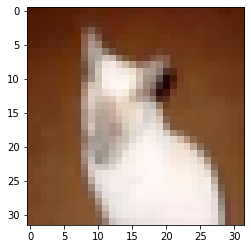

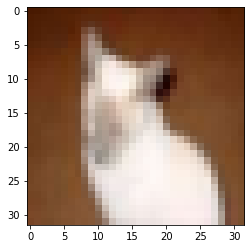

torch.Size([3, 32, 32])


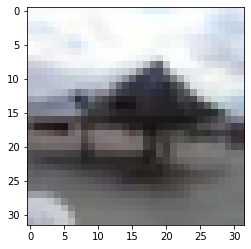

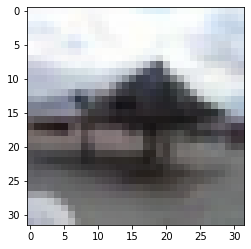

torch.Size([3, 32, 32])


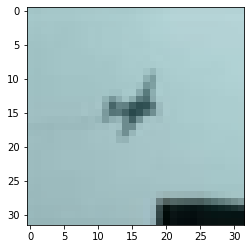

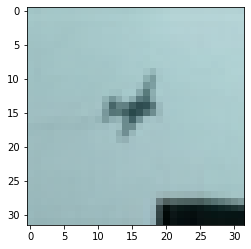

torch.Size([3, 32, 32])


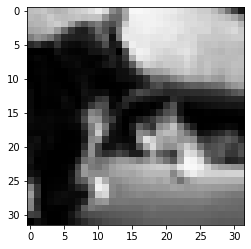

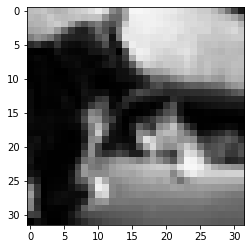

In [ ]:
import torchvision as TV
inv_normalize = transforms.Normalize(
        mean=mean,
        std=std
      )

   
for i in range(0,adversarial_examples.size()[0]):
  print(inputs[i].size())
  imshow(inputs[i])
  inv =inputs[i] / 2 + 0.5
  TV.utils.save_image(inv, "/content/drive/MyDrive/TFG/CW/logs/%d_original.png" %(i),)
  imshow(adversarial_examples[i])
  inv =adversarial_examples[i] / 2 + 0.5
  TV.utils.save_image(inv, "/content/drive/MyDrive/TFG/CW/logs/%d_adversarial.png" %(i))


#MNIST

In [ ]:
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content//MNIST', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5),
                           ])),batch_size=9, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content//MNIST', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5),
                           ])),batch_size=128, shuffle=True)

In [ ]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 10, kernel_size=3, stride=3)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 10 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = MnistCNN()

In [ ]:
model.to(device)



import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.029
[1,   400] loss: 0.023
[1,   600] loss: 0.022
[1,   800] loss: 0.021
[1,  1000] loss: 0.021
[1,  1200] loss: 0.020
[1,  1400] loss: 0.017
[1,  1600] loss: 0.017
[1,  1800] loss: 0.020
[1,  2000] loss: 0.017
[1,  2200] loss: 0.019
[1,  2400] loss: 0.016
[1,  2600] loss: 0.019
[1,  2800] loss: 0.016
[1,  3000] loss: 0.015
[1,  3200] loss: 0.016
[1,  3400] loss: 0.014
[1,  3600] loss: 0.016
[1,  3800] loss: 0.012
[1,  4000] loss: 0.013
[1,  4200] loss: 0.015
[1,  4400] loss: 0.012
[1,  4600] loss: 0.012
[1,  4800] loss: 0.012
[1,  5000] loss: 0.013
[1,  5200] loss: 0.014
[1,  5400] loss: 0.011
[1,  5600] loss: 0.010
[1,  5800] loss: 0.015
[1,  6000] loss: 0.010
[1,  6200] loss: 0.012
[1,  6400] loss: 0.009
[1,  6600] loss: 0.014
[2,   200] loss: 0.011
[2,   400] loss: 0.009
[2,   600] loss: 0.012
[2,   800] loss: 0.009
[2,  1000] loss: 0.010
[2,  1200] loss: 0.012
[2,  1400] loss: 0.010
[2,  1600] loss: 0.013
[2,  1800] loss: 0.008
[2,  2000] loss: 0.010
[2,  2200] 

In [ ]:
PATH = '/content/drive/MyDrive/TFG/MNIST/MNIST_net.pth'
torch.save(model.state_dict(), PATH)

torch.Size([128])
GroundTruth:  9 5 7 8


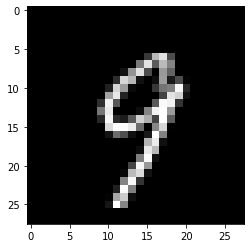

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels.shape)
#net = Net()
plt.imshow(images[0].reshape(28,28), cmap="gray")
#imshow(images[0])
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))

In [ ]:
model.load_state_dict(torch.load(PATH))

model.to(device)

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


dataiter = iter(train_loader) #inputs images
inputs, _ = dataiter.next()
inputs.to(device)
target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded


adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


Se han truncado las últimas 5000 líneas del flujo de salida.
pert_predictions_np: [6 0 1 0 5 5 3 1 3] 
pert_predictions_np: [3 3 1 0 5 5 3 3 3] 
pert_predictions_np: [3 0 3 3 5 5 3 3 3] 
pert_predictions_np: [3 3 3 3 5 5 3 3 2] 
pert_predictions_np: [6 0 3 3 5 3 2 3 2] 
pert_predictions_np: [3 0 3 3 5 3 2 1 2] 
batch 460 loss: 87.36589813232422
pert_predictions_np: [5 0 3 0 5 3 2 1 3] 
pert_predictions_np: [3 0 1 0 5 5 2 3 3] 
pert_predictions_np: [3 0 1 3 5 5 2 3 3] 
pert_predictions_np: [6 0 3 3 5 5 2 3 3] 
pert_predictions_np: [3 3 3 0 5 3 2 3 3] 
pert_predictions_np: [3 3 3 0 5 3 3 3 3] 
pert_predictions_np: [5 0 3 3 5 3 3 3 3] 
pert_predictions_np: [6 0 1 3 5 5 2 1 3] 
pert_predictions_np: [3 0 1 3 5 5 2 1 3] 
pert_predictions_np: [3 0 3 3 5 5 2 3 3] 
batch 470 loss: 87.2808837890625
pert_predictions_np: [3 0 3 0 5 3 2 3 2] 
pert_predictions_np: [8 3 3 0 5 3 2 3 2] 
pert_predictions_np: [8 0 3 0 5 3 2 1 2] 
pert_predictions_np: [3 0 1 3 5 3 2 3 3] 
pert_predictions_np: [3 3 1 3 5 

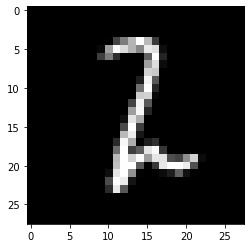

In [ ]:
import torchvision as TV
inv_normalize = transforms.Normalize(
        mean=mean,
        std=std
      )

plt.imshow(inputs[0].reshape(28,28), cmap="gray")
plt.imshow(adversarial_examples[0].reshape(28,28), cmap="gray")  
for i in range(0,adversarial_examples.size()[0]):
  #print(inputs[i].size())
  plt.imshow(inputs[i].reshape(28,28), cmap="gray")
  inv =inputs[i] / 2 + 0.5
  TV.utils.save_image(inputs[i].reshape(28,28), "/content/drive/MyDrive/TFG/CW/logs/%d_original.png" %(i),)
 
  inv =adversarial_examples[i] / 2 + 0.5
  TV.utils.save_image(adversarial_examples[i].reshape(28,28), "/content/drive/MyDrive/TFG/CW/logs/%d_adversarial.png" %(i))